# Data-Driven Discovery of Vehicle Dynamics Using Probabilistic Bayesian Neural Networks
## 2D DNN for Skidpad Maneuver
### Team: [Chinmay Samak](mailto:csamak@clemson.edu), [Tanmay Samak](mailto:tsamak@clemson.edu), [Vasanth Seethapathi](mailto:vasants@clemson.edu)

Import Libraries

In [1]:
import ntpath
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model

Import Data

In [2]:
# Define data directory
data_directory = 'AutoDRIVE-Nigel-Dataset/skidpad_30_hz'

In [3]:
def shorten_path(path):
    '''
    Function to view shortened paths.
    '''
    head,tail = ntpath.split(path)
    return tail

In [4]:
# Read the driving log
headers = ['timestamp','throttle','steering','leftTicks','rightTicks','posX','posY','posZ','roll','pitch','yaw','speed','angX','angY','angZ','accX','accY','accZ','cam0','cam1','lidar']

# Read each CSV file in dir "path/to/root_dir"
vehicle_logs = []
for file in Path(data_directory).glob("**/V1 Log.csv"):
    vehicle_logs.append(pd.read_csv(file, names=headers))

# Put the dataframes to a single dataframe
vehicle_log = pd.concat(vehicle_logs)

# Convert timestamp from string to datetime format
vehicle_log['timestamp'] = pd.to_datetime(vehicle_log['timestamp'], format='%Y_%m_%d_%H_%M_%S_%f')

# Shorten camera frame paths
vehicle_log['cam0'] = vehicle_log['cam0'].apply(shorten_path)
vehicle_log['cam1'] = vehicle_log['cam1'].apply(shorten_path)

# View the first 5 entries in the dataframe
vehicle_log.head()

,timestamp,throttle,steering,leftTicks,rightTicks,posX,posY,posZ,roll,pitch,...,speed,angX,angY,angZ,accX,accY,accZ,cam0,cam1,lidar
0,2023-04-13 23:46:17.648,0.0,0.0,0,0,8.940697e-07,5.560414e-08,0.032498,-1.842617e-07,-3.635517e-09,...,0.0,6.208085e-08,-0.000014,4.238477e-11,4.376943e-08,1.158580e-07,0.0,Camera0_Frame_2023_04_13_23_46_17_648.jpg,Camera1_Frame_2023_04_13_23_46_17_648.jpg,3.618262 3.624363 3.631593 3.639963 3.649485 3...
1,2023-04-13 23:46:17.688,0.0,0.0,0,0,8.940697e-07,5.559934e-08,0.032498,-2.342875e-07,-3.614351e-09,...,0.0,-1.722123e-09,-0.000014,4.215222e-11,4.376943e-08,1.155169e-07,0.0,Camera0_Frame_2023_04_13_23_46_17_688.jpg,Camera1_Frame_2023_04_13_23_46_17_688.jpg,3.618262 3.624363 3.631593 3.639963 3.649485 3...
2,2023-04-13 23:46:17.732,0.0,0.0,0,0,8.940697e-07,5.558071e-08,0.032498,-1.409060e-07,-3.652612e-09,...,0.0,-6.843676e-08,-0.000014,4.260872e-11,4.376943e-08,1.151608e-07,0.0,Camera0_Frame_2023_04_13_23_46_17_732.jpg,Camera1_Frame_2023_04_13_23_46_17_732.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
3,2023-04-13 23:46:17.770,0.0,0.0,0,0,8.940697e-07,5.565722e-08,0.032498,7.837374e-08,-3.725058e-09,...,0.0,-1.272237e-07,-0.000014,4.265325e-11,4.354206e-08,1.148503e-07,0.0,Camera0_Frame_2023_04_13_23_46_17_770.jpg,Camera1_Frame_2023_04_13_23_46_17_770.jpg,inf inf inf inf inf inf inf inf inf inf inf in...
4,2023-04-13 23:46:17.808,0.0,0.0,0,0,8.940697e-07,5.579648e-08,0.032498,2.818120e-07,-3.784479e-09,...,0.0,1.170755e-07,-0.000015,1.016474e-10,4.342837e-08,2.859881e-07,0.0,Camera0_Frame_2023_04_13_23_46_17_808.jpg,Camera1_Frame_2023_04_13_23_46_17_808.jpg,inf inf inf inf inf inf inf inf inf inf inf in...


Visualize Raw Data

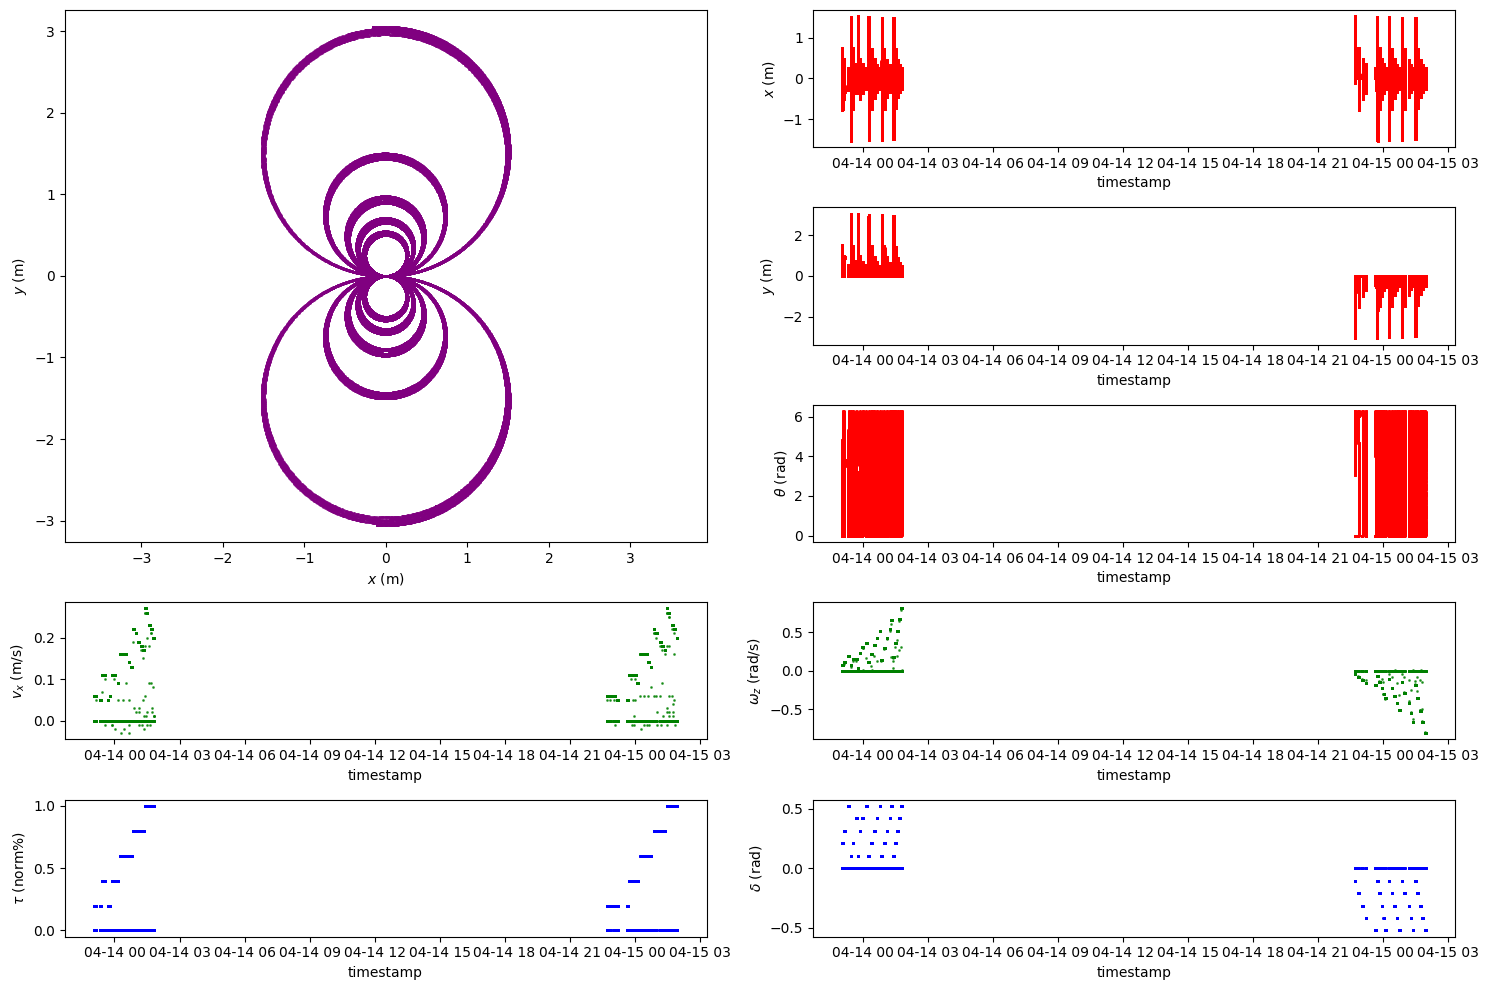

In [5]:
# Set figure size and sub-plot grid
fig = plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(5, 2)

# Plot Y-position vs. X-position
axes_1 = plt.subplot(G[0:3, 0])
axes_1.scatter(np.asarray(vehicle_log['posX']), np.asarray(vehicle_log['posY']), s=1, color='purple', alpha=0.7)
axes_1.axis('equal')
axes_1.set_xlabel(r"$x$ (m)")
axes_1.set_ylabel(r"$y$ (m)")

# Plot X-position vs. elapsed time
axes_2 = plt.subplot(G[0, 1])
axes_2.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['posX']), s=1, color='red', alpha=0.7)
axes_2.set_xlabel(r"timestamp")
axes_2.set_ylabel(r"$x$ (m)")

# Plot Y-position vs. elapsed time
axes_3 = plt.subplot(G[1, 1])
axes_3.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['posY']), s=1, color='red', alpha=0.7)
axes_3.set_xlabel(r"timestamp")
axes_3.set_ylabel(r"$y$ (m)")

# Plot yaw vs. elapsed time
axes_4 = plt.subplot(G[2, 1])
axes_4.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['yaw']), s=1, color='red', alpha=0.7)
axes_4.set_xlabel(r"timestamp")
axes_4.set_ylabel(r"$\theta$ (rad)")

# Plot speed vs. elapsed time
axes_5 = plt.subplot(G[3, 0])
axes_5.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['speed']), s=1, color='green', alpha=0.7)
axes_5.set_xlabel(r"timestamp")
axes_5.set_ylabel(r"$v_x$ (m/s)")

# Plot yaw rate vs. elapsed time
axes_6 = plt.subplot(G[3, 1])
axes_6.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['angZ']), s=1, color='green', alpha=0.7)
axes_6.set_xlabel(r"timestamp")
axes_6.set_ylabel(r"$\omega_z$ (rad/s)")

# Plot throttle vs. elapsed time
axes_7 = plt.subplot(G[4, 0])
axes_7.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['throttle']), s=1, color='blue', alpha=0.7)
axes_7.set_xlabel(r"timestamp")
axes_7.set_ylabel(r"$\tau$ (norm%)")

# Plot steering angle vs. elapsed time
axes_8 = plt.subplot(G[4, 1])
axes_8.scatter(np.asarray(vehicle_log['timestamp']), np.asarray(vehicle_log['steering']), s=1, color='blue', alpha=0.7)
axes_8.set_xlabel(r"timestamp")
axes_8.set_ylabel(r"$\delta$ (rad)")

# Show the plot
plt.tight_layout()
plt.show()

Load Dataset

In [7]:
def load_dataset():
  '''
    Function to load dataset.
  '''
  x = vehicle_log[['throttle', 'steering']]
  y = vehicle_log[['speed', 'angZ']]
  x[['throttle', 'steering']].apply(tuple, axis=1).tolist()
  y[['speed', 'angZ']].apply(tuple, axis=1).tolist()
  x.to_numpy()
  y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
  return x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy()

x_train, y_train, x_test, y_test = load_dataset()

Visualize Dataset

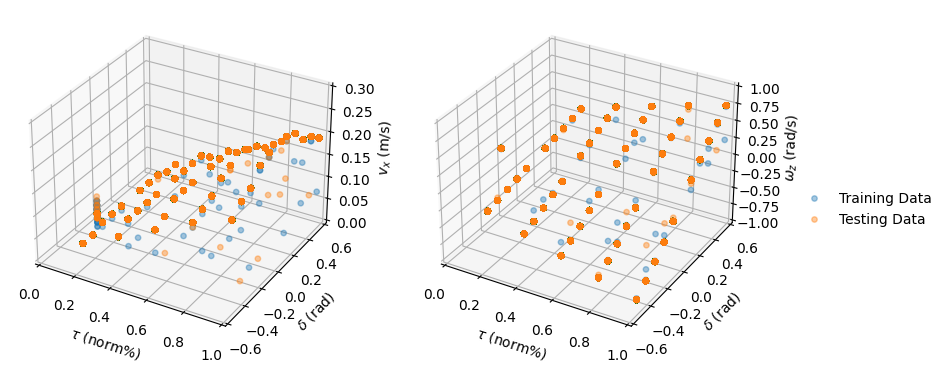

In [8]:
# Set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# ===============
# Linear velocity
# ===============
ax = fig.add_subplot(1, 2, 1, projection='3d') # Set up 3D axes
ax.scatter3D(x_train[:,0], x_train[:,1], y_train[:,0], s=15, label="Training Data", alpha=0.4) # Plot training data
ax.scatter3D(x_test[:,0], x_test[:,1], y_test[:,0], s=15, label="Testing Data", alpha=0.4) # Plot testing data

# Add labels and set axes limits
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(0, 0.3)
ax.set_xlabel(r"$\tau$ (norm%)")
ax.set_ylabel(r"$\delta$ (rad)")
ax.set_zlabel(r"$v_x$ (m/s)")

# ================
# Angular velocity
# ================
ax = fig.add_subplot(1, 2, 2, projection='3d') # Set up 3D axes
ax.scatter3D(x_train[:,0], x_train[:,1], y_train[:,1], s=15, label="Training Data", alpha=0.4) # Plot training data
ax.scatter3D(x_test[:,0], x_test[:,1], y_test[:,1], s=15, label="Testing Data", alpha=0.4) # Plot testing data

# Add labels and set axes limits
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-1.0, 1.0)
ax.set_xlabel(r"$\tau$ (norm%)")
ax.set_ylabel(r"$\delta$ (rad)")
ax.set_zlabel(r"$\omega_z$ (rad/s)")

# Add legend and show the plot
plt.legend(fancybox=True, framealpha=0., bbox_to_anchor=(1.1, 0.5))
plt.show()

Define DNN Model

In [9]:
# Create deep neural network model
def DNNmodel():
    model = Sequential()
    model.add(Dense(16, input_shape = (2, ), activation = 'relu', name = 'FC1'))
    model.add(Dense(32, activation = 'relu', name = 'FC2'))
    #model.add(Dropout(0.25, name = 'DROP1'))
    model.add(Dense(64, activation = 'relu', name = 'FC3'))
    #model.add(Dropout(0.25, name = 'DROP2'))
    model.add(Dense(8, activation = 'relu', name = 'FC4'))
    #model.add(Dropout(0.25, name = 'DROP3'))
    model.add(Dense(2, name = 'OUTPUT'))
    return model

model = DNNmodel()
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FC1 (Dense)                 (None, 16)                48        
                                                                 
 FC2 (Dense)                 (None, 32)                544       
                                                                 
 FC3 (Dense)                 (None, 64)                2112      
                                                                 
 FC4 (Dense)                 (None, 8)                 520       
                                                                 
 OUTPUT (Dense)              (None, 2)                 18        
                                                                 
Total params: 3,242
Trainable params: 3,242
Non-trainable params: 0
_________________________________________________________________


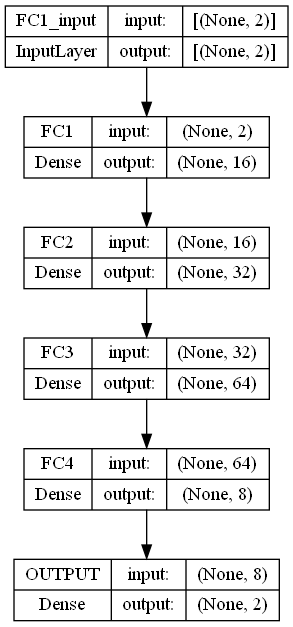

In [10]:
# Plot the model
plot_model(model, to_file='DNN.png', show_shapes=True, show_layer_names=True)

Train DNN Model

In [11]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, verbose=True)

Epoch 1/10
1951/1951 [==============================] - 8s 4ms/step - loss: 0.0014 - val_loss: 4.2959e-05
Epoch 2/10
1951/1951 [==============================] - 9s 5ms/step - loss: 2.8088e-05 - val_loss: 3.6765e-05
Epoch 3/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.4529e-05 - val_loss: 3.8126e-05
Epoch 4/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.5027e-05 - val_loss: 7.1723e-05
Epoch 5/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.5339e-05 - val_loss: 3.4183e-05
Epoch 6/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.1247e-05 - val_loss: 3.4098e-05
Epoch 7/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.0364e-05 - val_loss: 3.3510e-05
Epoch 8/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.1108e-05 - val_loss: 3.2972e-05
Epoch 9/10
1951/1951 [==============================] - 10s 5ms/step - loss: 2.1548e-05 - val_loss: 3.2764e-05
Epoch 1

Visualize Training Performance

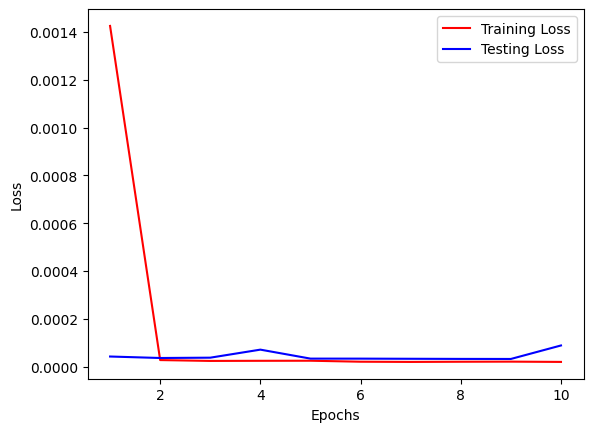

In [12]:
# Get training and testing losses for all the epochs from `history`
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Plot the training and testing loses
plt.figure()
plt.plot(np.asarray(epochs)+1, loss, 'r', label='Training Loss')
plt.plot(np.asarray(epochs)+1, val_loss, 'b', label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualize De-Coupled Predictions

488/488 [==============================] - 1s 1ms/step


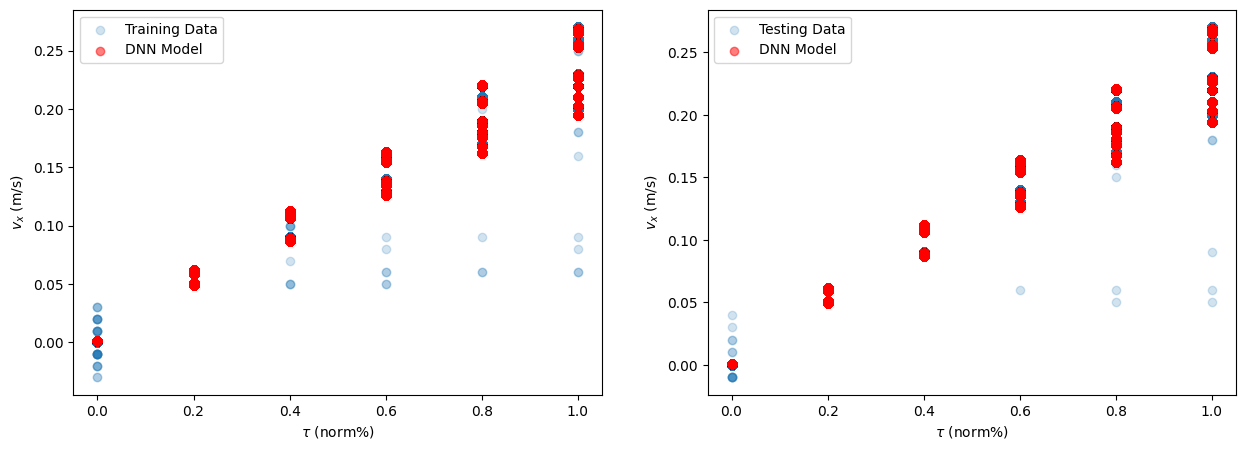

In [13]:
# Set figure size
figure, axes = plt.subplots(1, 2, figsize = (15, 5))

# Training data
axes[0].scatter(x_train[:,0], y_train[:,0], alpha=0.2, label='Training Data')
y_hat = model.predict(x_train)
axes[0].scatter(x_train[:,0], y_hat[:,0], color='red', alpha=0.5, label='DNN Model')
axes[0].set_xlabel(r"$\tau$ (norm%)")
axes[0].set_ylabel(r"$v_x$ (m/s)")
axes[0].legend(loc='best')

# Testing data
axes[1].scatter(x_test[:,0], y_test[:,0], alpha=0.2, label='Testing Data')
y_hat = model.predict(x_test)
axes[1].scatter(x_test[:,0], y_hat[:,0], color='red', alpha=0.5, label='DNN Model')
axes[1].set_xlabel(r"$\tau$ (norm%)")
axes[1].set_ylabel(r"$v_x$ (m/s)")
axes[1].legend(loc='best')

# Show plot
plt.show()

488/488 [==============================] - 1s 1ms/step


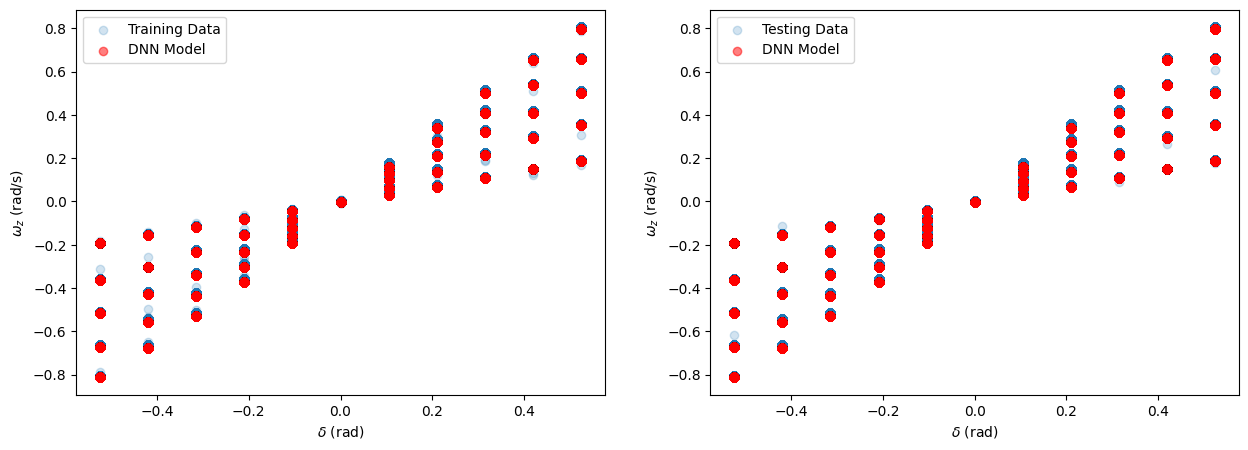

In [14]:
# Set figure size
figure, axes = plt.subplots(1, 2, figsize = (15, 5))

# Training data
axes[0].scatter(x_train[:,1], y_train[:,1], alpha=0.2, label='Training Data')
y_hat = model.predict(x_train)
axes[0].scatter(x_train[:,1], y_hat[:,1], color='red', alpha=0.5, label='DNN Model')
axes[0].set_xlabel(r"$\delta$ (rad)")
axes[0].set_ylabel(r"$\omega_z$ (rad/s)")
axes[0].legend(loc='best')

# Testing data
axes[1].scatter(x_test[:,1], y_test[:,1], alpha=0.2, label='Testing Data')
y_hat = model.predict(x_test)
axes[1].scatter(x_test[:,1], y_hat[:,1], color='red', alpha=0.5, label='DNN Model')
axes[1].set_xlabel(r"$\delta$ (rad)")
axes[1].set_ylabel(r"$\omega_z$ (rad/s)")
axes[1].legend(loc='best')

# Show plot
plt.show()

Visualize Coupled Predictions

1951/1951 [==============================] - 3s 1ms/step


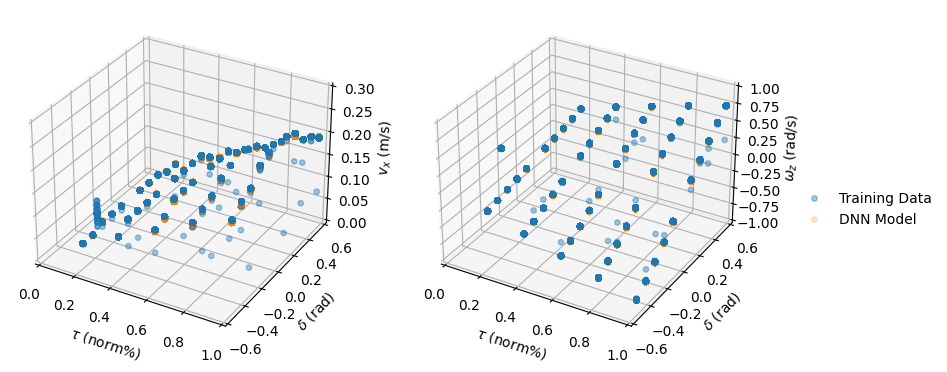

In [15]:
# Visualize predictions
fig = plt.figure(figsize=plt.figaspect(0.5)) # Set up a figure twice as wide as it is tall

# ===============
# Linear velocity
# ===============
ax = fig.add_subplot(1, 2, 1, projection='3d') # Set up 3D axes
ax.scatter3D(x_train[:,0], x_train[:,1], y_train[:,0], s=15, label="Training Data", alpha=0.4) # Plot training data
y_hat = model.predict(x_train)
ax.scatter3D(x_train[:,0], x_train[:,1], y_hat[:,0], s=15, alpha=0.2, label='DNN Model')

# Add labels and set axes limits
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(0, 0.3)
ax.set_xlabel(r"$\tau$ (norm%)")
ax.set_ylabel(r"$\delta$ (rad)")
ax.set_zlabel(r"$v_x$ (m/s)")

# ================
# Angular velocity
# ================
ax = fig.add_subplot(1, 2, 2, projection='3d') # Set up 3D axes
ax.scatter3D(x_train[:,0], x_train[:,1], y_train[:,1], s=15, label="Training Data", alpha=0.4) # Plot training data
y_hat = model.predict(x_train)
ax.scatter3D(x_train[:,0], x_train[:,1], y_hat[:,1], s=15, alpha=0.2, label='DNN Model')

# Add labels and set axes limits
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-1.0, 1.0)
ax.set_xlabel(r"$\tau$ (norm%)")
ax.set_ylabel(r"$\delta$ (rad)")
ax.set_zlabel(r"$\omega_z$ (rad/s)")

# Add legend and show the plot
plt.legend(fancybox=True, framealpha=0., bbox_to_anchor=(1.1, 0.5))
plt.show()

488/488 [==============================] - 1s 1ms/step


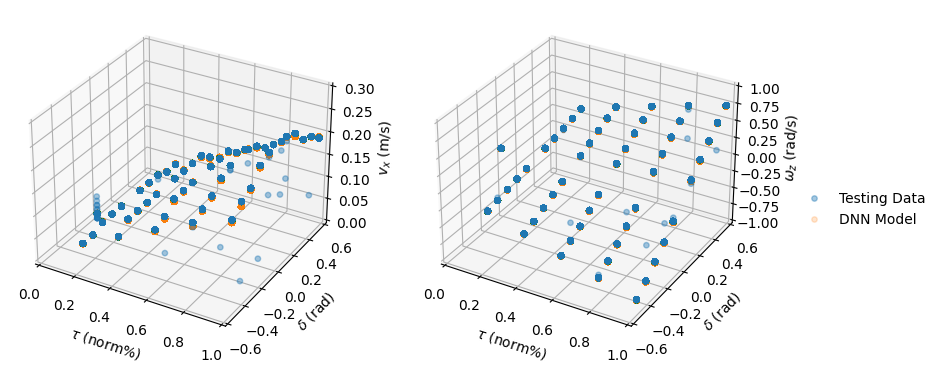

In [16]:
# Visualize predictions
fig = plt.figure(figsize=plt.figaspect(0.5)) # Set up a figure twice as wide as it is tall

# ===============
# Linear velocity
# ===============
ax = fig.add_subplot(1, 2, 1, projection='3d') # Set up 3D axes
ax.scatter3D(x_test[:,0], x_test[:,1], y_test[:,0], s=15, label="Testing Data", alpha=0.4) # Plot training data
y_hat = model.predict(x_test)
ax.scatter3D(x_test[:,0], x_test[:,1], y_hat[:,0], s=15, alpha=0.2, label='DNN Model')

# Add labels and set axes limits
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(0, 0.3)
ax.set_xlabel(r"$\tau$ (norm%)")
ax.set_ylabel(r"$\delta$ (rad)")
ax.set_zlabel(r"$v_x$ (m/s)")

# ================
# Angular velocity
# ================
ax = fig.add_subplot(1, 2, 2, projection='3d') # Set up 3D axes
ax.scatter3D(x_test[:,0], x_test[:,1], y_test[:,1], s=15, label="Testing Data", alpha=0.4) # Plot training data
y_hat = model.predict(x_test)
ax.scatter3D(x_test[:,0], x_test[:,1], y_hat[:,1], s=15, alpha=0.2, label='DNN Model')

# Add labels and set axes limits
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.6, 0.6)
ax.set_zlim(-1.0, 1.0)
ax.set_xlabel(r"$\tau$ (norm%)")
ax.set_ylabel(r"$\delta$ (rad)")
ax.set_zlabel(r"$\omega_z$ (rad/s)")

# Add legend and show the plot
plt.legend(fancybox=True, framealpha=0., bbox_to_anchor=(1.1, 0.5))
plt.show()